# HSE 2025: Mathematical Methods for Data Analysis

## Assignment 2: Classification

**Topic:** Binary and Multiclass Text Classification with Logistic Regression and SVM



In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

##### Put your markdown formulas here

$$
\nabla _w L(w) = \sum_{i=1}^{N} -y_i \nabla _w \log{\sigma{(w^\top x_i)}} - (1 - y_i) \nabla _w \log{(1 - \sigma{(w^\top x_i)})} + \gamma sign(w) + 2\beta w
$$

First term of the sum:

$$
-y_i \nabla _w \log{\sigma{(w^\top x_i)}} = y_i \frac{1}{\sigma{(w^\top x_i)}} \cdot \frac{- e^{-w^\top x_i}}{1 + e^{-w^\top x_i}} x_i = -y_i \frac{e^{-w^\top x_i}}{1 + e^{-w^\top x_i}} x_i
$$

Second term of the sum:

$$
-(1 - y_i) \nabla _w \log{(1 - \sigma{(w^\top x_i)})} = (1 - y_i) \frac{1}{1 + e^{-w^\top x_i}} x_i
$$

All together:

$$
\nabla _w L(w) = \gamma sign(w) + 2\beta w + \sum_{i=1}^{N} (\sigma{(w^\top x_i)} - y_i) \cdot x_i
$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [2]:
def loss(X, y, w: List[float], gamma=1.0, beta=1.0) -> float:
    w = np.array(w)
    l = np.sum(-y * np.log(sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - sigmoid(np.dot(X, w)))) + gamma * np.linalg.norm(w, 1) + beta * np.linalg.norm(w) ** 2
    return  l

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

loss(np.array([[1, 2], [3, 4]]), np.array([0, 1]), np.array([1, 1]))

7.049498818027519

#### 3. [0.25 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    w = np.array(w)
    
    grad_w = gamma * np.sign(w) + 2 * beta * w + np.dot(X.T, (sigmoid(np.dot(X, w)) - y))

    return grad_w.tolist()

get_grad(np.array([[1, 2], [3, 4]]), np.array([0, 1]), np.array([1, 1]))

[3.9498409732392314, 4.901504048867264]

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
assert np.allclose(
    grad_w, [-3.99447493, -1.84786723, 0.64520104, 1.67059973, -5.03858487, -5.21496336], rtol=1e-2
)

In [5]:
grad_w

[-3.9944749293597632,
 -1.84786722778556,
 0.6452010421087129,
 1.6705997291223378,
 -5.038584867279209,
 -5.214963362606358]

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(
        self, beta=0.1, gamma=0.1, lr=1e-3, tolerance=1e-6, max_iter=1000, random_state=42, threshold=0.5
    ):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.lr = lr
        self.random_state = random_state
        self.w = None
        self.classes_ = None
        # you may additional properties if you wish

        # Decison boundary
        self.threshold = threshold

        self.loss_history = None

        np.random.seed(self.random_state)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        # Adding intercept
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        y = np.asarray(y, dtype=float).reshape(-1, 1)
        self.loss_history = []

        self.w = np.random.uniform(0, 1, (X.shape[1], 1))

        for i in range(self.max_iter):
            self.loss_history.append(self.loss(X, y, self.w))

            w_new = None

            grad = self.get_grad(X, y, self.w)

            w_new = self.w - self.learning_rate * grad

            if (np.linalg.norm(self.w - w_new) < self.tolerance):
                break

            self.w = w_new

        return self
    
    def get_grad(self, X, y, w: List[float]):
        w = np.array(w)
        w0 = w.copy()
    
        grad_w = self.gamma * np.sign(w0) + 2 * self.beta * w0 + np.dot(X.T, (self.sigmoid(np.dot(X, w)) - y))

        return grad_w
    
    def loss(self, X, y, w: List[float]) -> float:
        w = np.array(w)
        w0 = w.copy()
        l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
        return  l
    
    def sigmoid(self, a):
        return 1.0 / (1.0 + np.exp(-a))

    def predict(self, X):
        # return vector of predicted labels (0 or 1) for each object from X
        X = np.asarray(X, dtype=float)

        predict = np.where(self.predict_proba(X)[:,1] >= self.threshold, 1, 0)

        return predict

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        # return vector of probabilities for each object from X
        proba = np.column_stack([1 - self.sigmoid(np.dot(X, self.w)), self.sigmoid(np.dot(X, self.w))])
        return proba

In [58]:
# sample data to test your model
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=180,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=42,
    n_clusters_per_class=1,
)

In [83]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200), np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    print(ypred)
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

[0 0 0 ... 1 1 1]


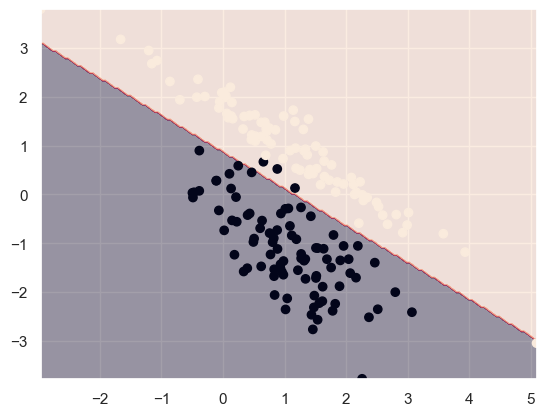

In [84]:
model = Logit()
model.fit(X, y)
plot_decision_boundary(model, X, y)

In [85]:
print(model.loss_history)

[106.59524993913506, 96.08211843868284, 87.66582398990654, 80.96785996597914, 75.64363501038467, 71.39997265851622, 67.99757457084063, 65.24639758093086, 62.99833897637272, 61.139425114210226, 59.58258909342011, 58.26151898359323, 57.12569309889497, 56.13674093490173, 55.271017933792685, 54.49887799045671, 53.80271974342888, 53.168798403987466, 52.586312569477386, 52.04671977667995, 51.54322113512339, 51.07037124122132, 50.62378128762184, 50.19989183724595, 49.79579795146054, 49.40911388195799, 49.03786782766857, 48.68041966413219, 48.33539631972837, 48.00164077758131, 47.678171650219795, 47.36415099684238, 47.05885859557131, 46.761671292546545, 46.47204636039603, 46.18950803555541, 45.91363658549701, 45.6440593967474, 45.38044368271603, 45.122490494359475, 44.86992978222079, 44.62251630968033, 44.38002625756586, 44.142254392061844, 43.909011693014875, 43.68012335970355, 43.4554271270446, 43.23477183790934, 43.018016227398284, 42.805027883093544, 42.5956823518893, 42.38986236931425, 42

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

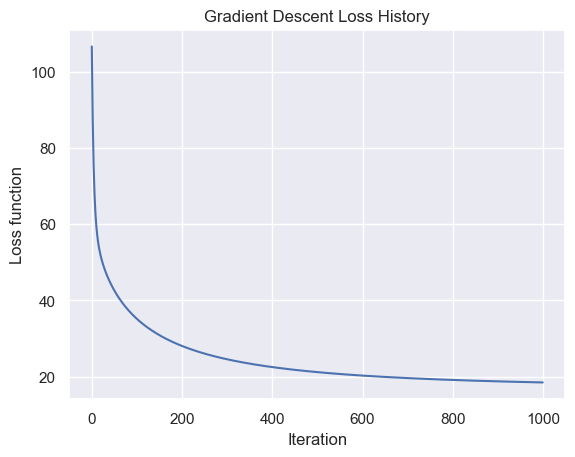

In [86]:
# your code here
history = model.loss_history

plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Loss function")
plt.title("Gradient Descent Loss History")
plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

#### Answers:

1. We can see that almost all models are very sensitive to regularization. If the coefficient becomes small (0.001), the F-1 score becomes much less
2. Different kernels show approximately the same results with similar hyperparameters.   
Likely due to the small sample
3. As said before, models are most sensivite to regularization coefficient
4. Honestly I haven't seen any models being overfitted. Maybe RBF with C=0.01 (as it has a slightly better performance on the train data - but that's not very significant).   
To spot overfitting we'd rather have a different, more arbitrary sample

Fitting 2 folds for each of 96 candidates, totalling 192 fits
[CV 1/2] END C=0.001, degree=1, kernel=linear, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/2] END C=0.001, degree=1, kernel=linear, tol=0.001;, score=0.667 total time=   0.0s
[CV 1/2] END C=0.001, degree=1, kernel=linear, tol=0.01;, score=0.800 total time=   0.0s
[CV 2/2] END C=0.001, degree=1, kernel=linear, tol=0.01;, score=0.667 total time=   0.0s
[CV 1/2] END C=0.001, degree=1, kernel=linear, tol=0.1;, score=0.800 total time=   0.0s
[CV 2/2] END C=0.001, degree=1, kernel=linear, tol=0.1;, score=0.667 total time=   0.0s
[CV 1/2] END C=0.001, degree=1, kernel=rbf, tol=0.001;, score=0.862 total time=   0.0s
[CV 2/2] END C=0.001, degree=1, kernel=rbf, tol=0.001;, score=0.667 total time=   0.0s
[CV 1/2] END C=0.001, degree=1, kernel=rbf, tol=0.01;, score=0.862 total time=   0.0s
[CV 2/2] END C=0.001, degree=1, kernel=rbf, tol=0.01;, score=0.667 total time=   0.0s
[CV 1/2] END C=0.001, degree=1, kernel=rbf, tol=0.1;, scor

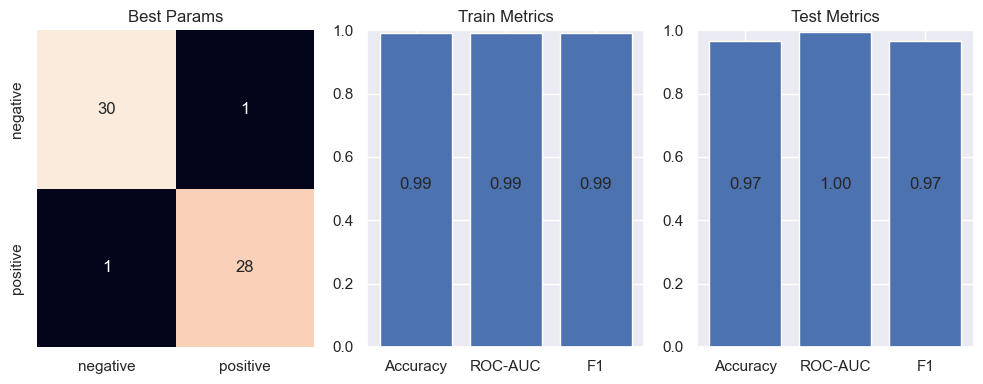

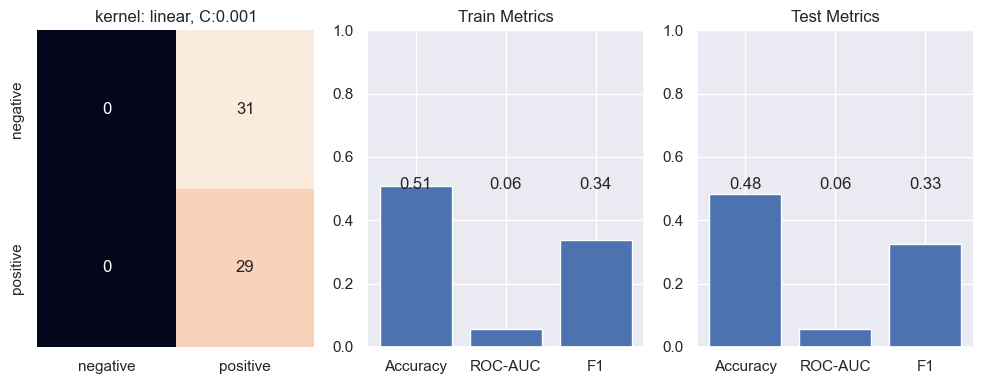

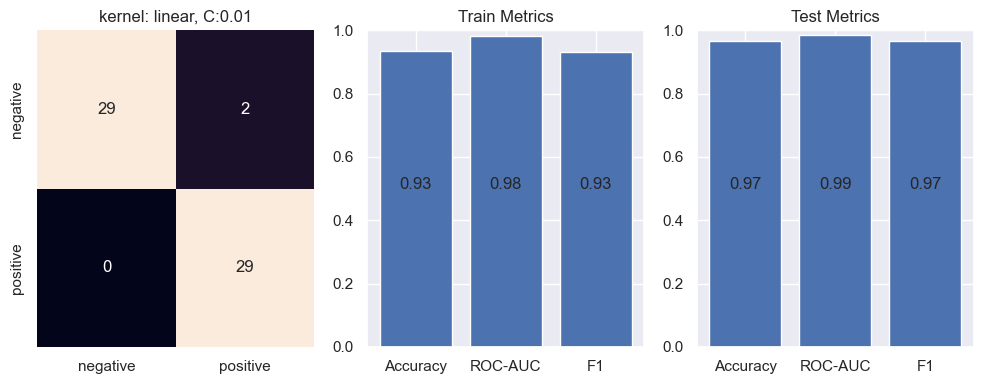

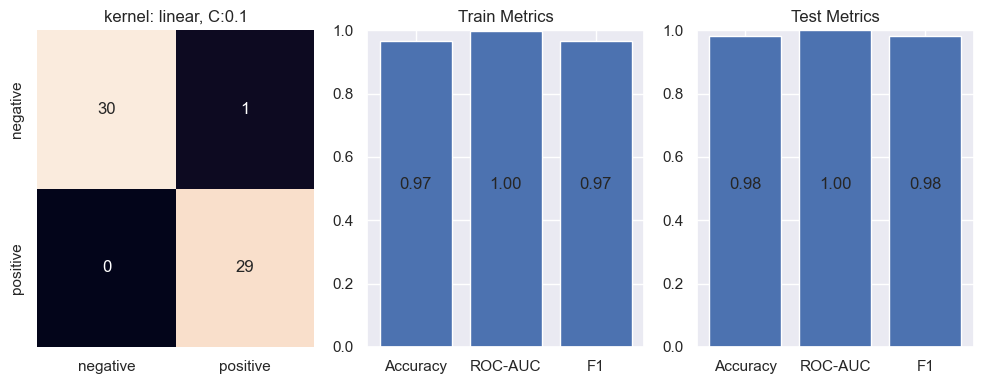

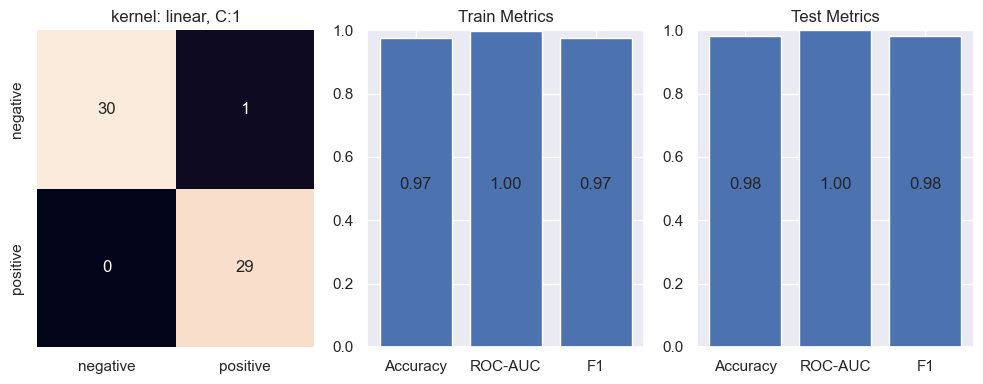

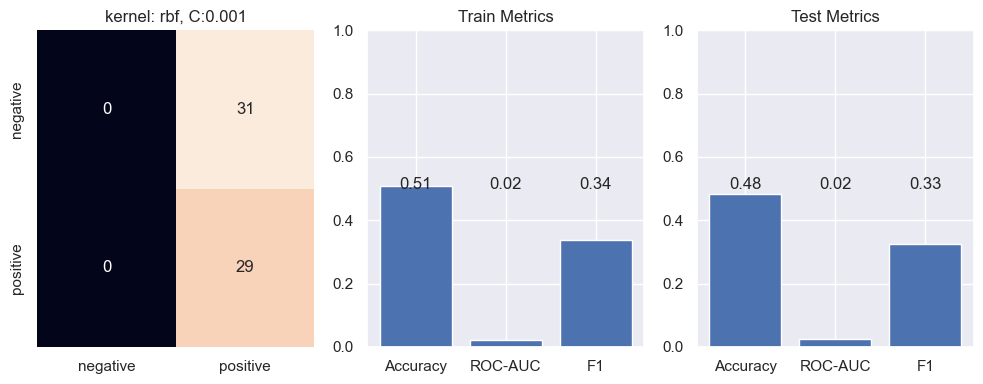

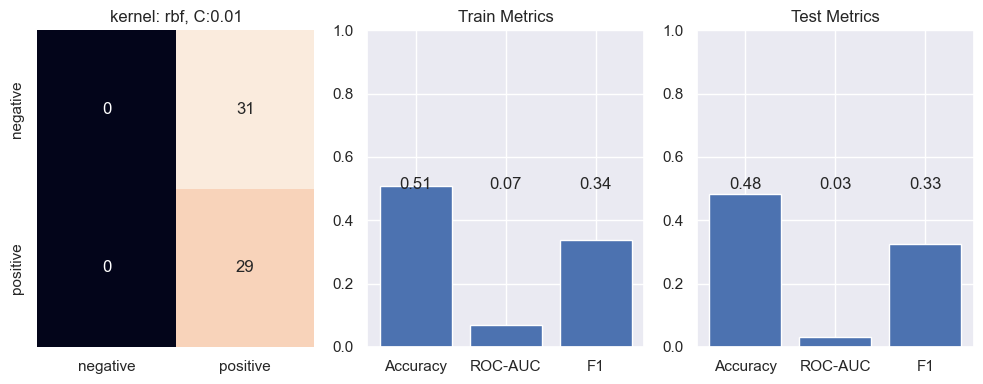

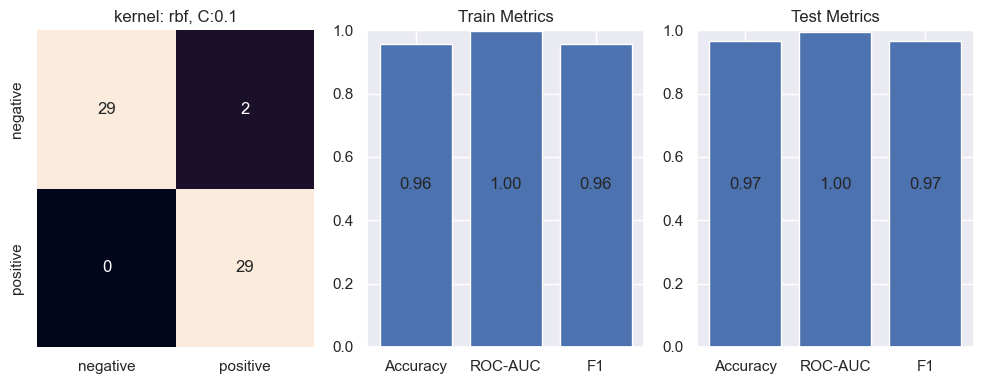

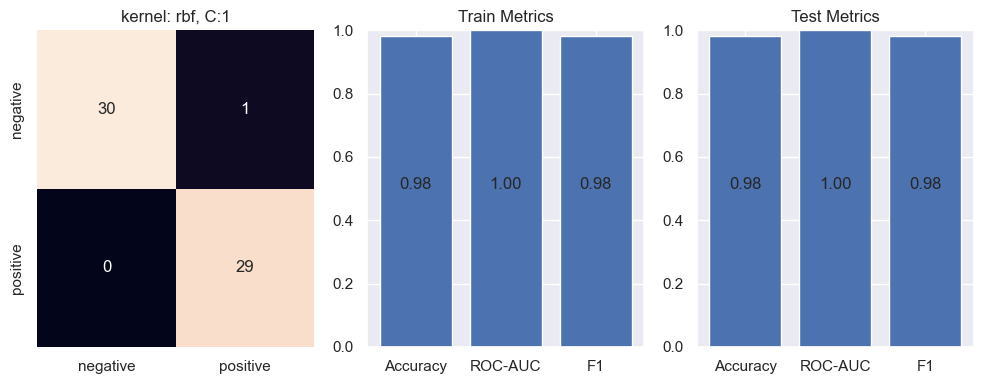

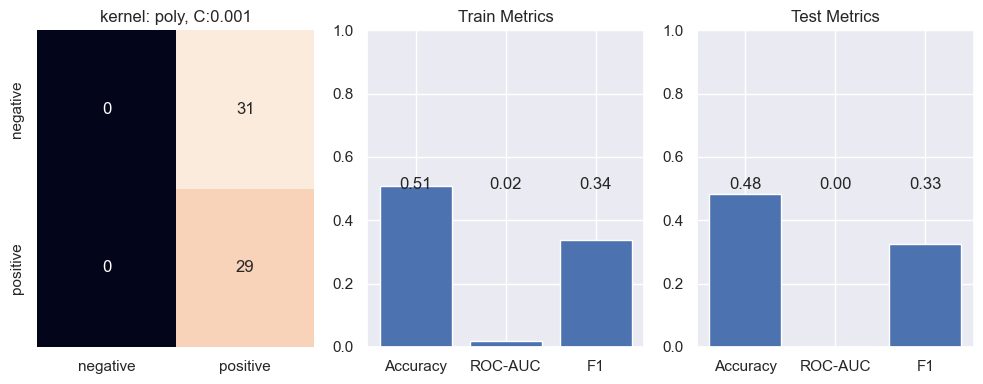

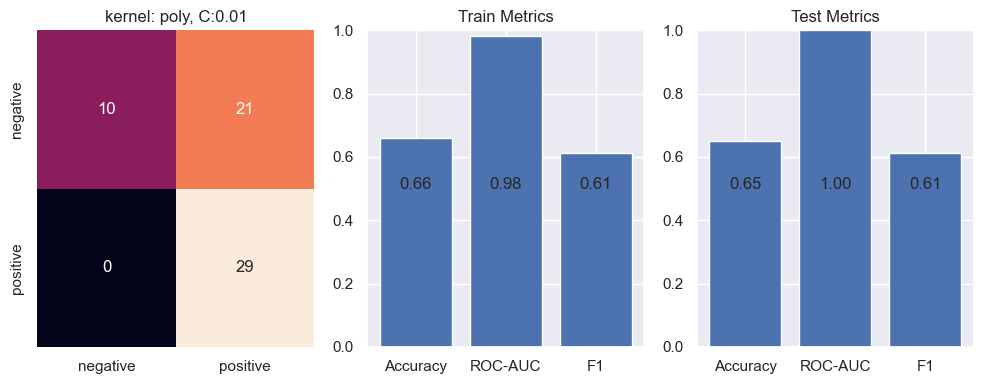

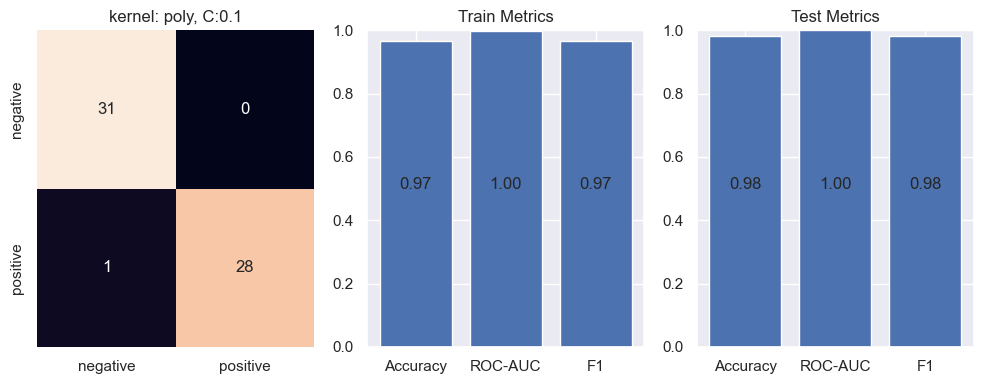

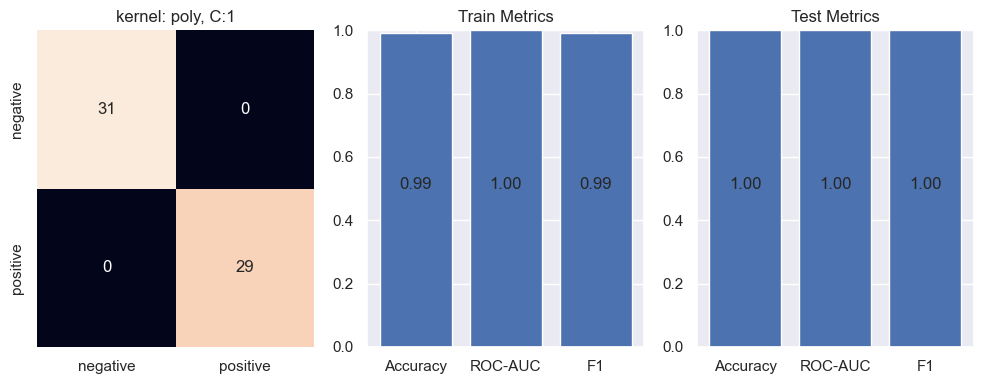

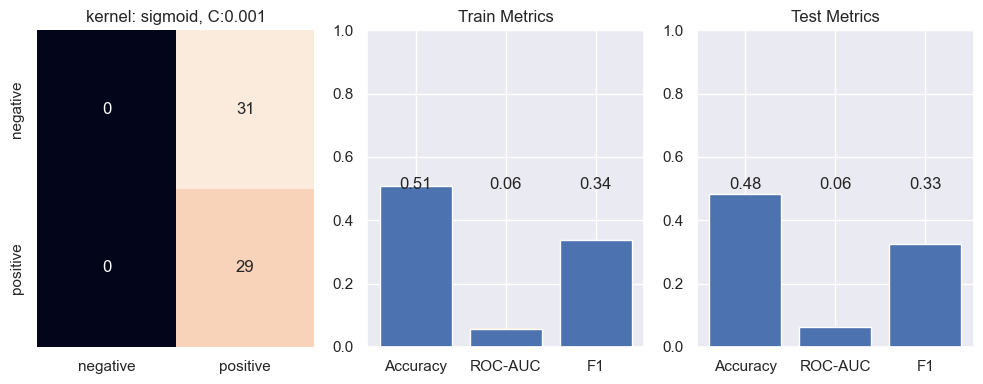

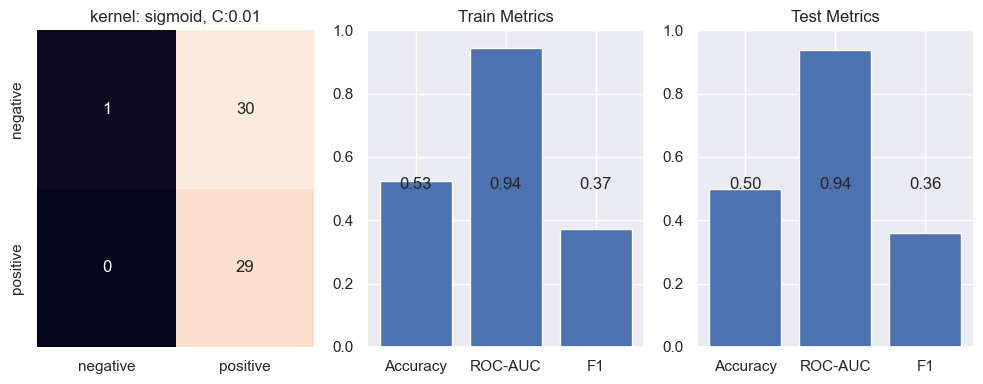

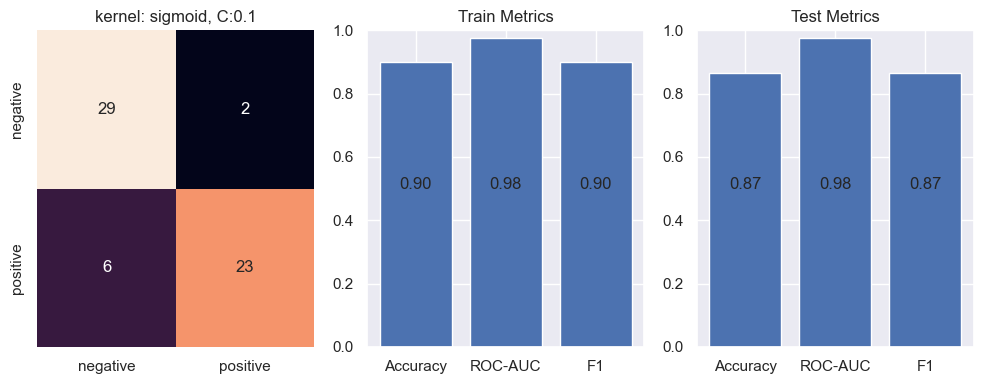

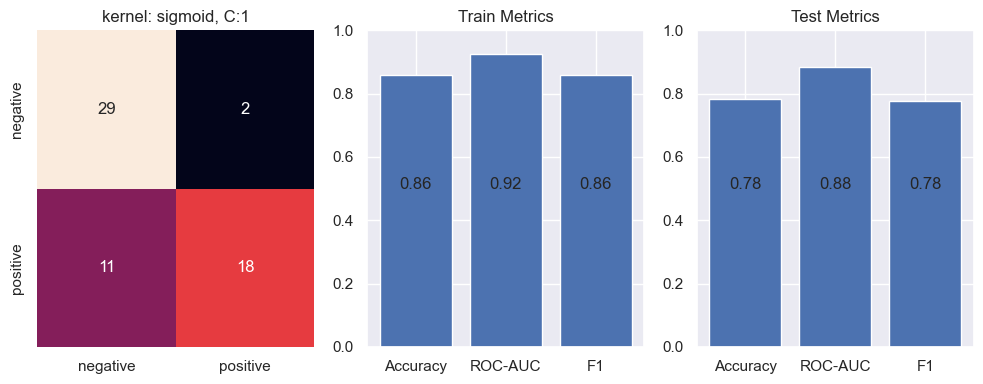

In [88]:
# your code here

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#train test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


def show_results(test_y, pred, proba, train_y, pred_train, proba_train, title):

    labels = ['negative', 'positive']

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title(title)

    train_metrics = {"Accuracy": accuracy_score(train_y, pred_train), "ROC-AUC": roc_auc_score(train_y, proba_train[:,1]), "F1": f1_score(train_y, pred_train, average='macro')}

    ax2.bar(train_metrics.keys(), train_metrics.values(), color='C0')
    ax2.set_ylim(0,1)
    for i,(k,v) in enumerate(train_metrics.items()):
        ax2.text(i, 0.5, f"{v:.2f}", ha='center')
    ax2.set_title("Train Metrics")

    test_metrics = {"Accuracy": accuracy_score(test_y, pred), "ROC-AUC": roc_auc_score(test_y, proba[:,1]), "F1": f1_score(test_y, pred, average='macro')}

    ax3.bar(test_metrics.keys(), test_metrics.values(), color='C0')
    ax3.set_ylim(0,1)
    for i,(k,v) in enumerate(test_metrics.items()):
        ax3.text(i, 0.5, f"{v:.2f}", ha='center')
    ax3.set_title("Test Metrics")

    plt.tight_layout()
    plt.show()

parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[0.001, 0.01, 0.1, 1], 'degree':[1, 2], 'tol':[1e-3, 0.01, 0.1]}
svr = SVC(probability=True, verbose = False, random_state=42)
clf = GridSearchCV(svr, parameters, scoring = 'f1', verbose=3, cv=2)
clf.fit(X_train, y_train)

print(clf.best_params_)
pred = clf.predict(X_test)
proba  = clf.predict_proba(X_test)
show_results(y_test, pred, proba, y_train, clf.predict(X_train),clf.predict_proba(X_train), "Best Params")

cvres = clf.cv_results_
order = np.argsort(clf.cv_results_['mean_test_score'])
top = min(10, len(order))

for rank_i, idx in enumerate(order[:top], start=1):
    params = clf.cv_results_['params'][idx]
    # train fresh model with these params on full train set
    svr = SVC(**params, probability=True, random_state=42)
    svr.fit(X_train, y_train)
    pred = svr.predict(X_test)
    proba = svr.predict_proba(X_test)
    title = str(params)
    # print(title)
    # show_results(y_test, pred, proba, title)

for kernel in parameters['kernel']:
    for c in parameters['C']:
        svr = SVC(kernel=kernel, C=c, probability=True, random_state=42)
        svr.fit(X_train, y_train)
        pred = svr.predict(X_test)
        proba = svr.predict_proba(X_test)
        pred_train = svr.predict(X_train)
        proba_train = svr.predict_proba(X_train)
        title = str(f"kernel: {kernel}, C:{c}")
        show_results(y_test, pred, proba, y_train, pred_train, proba_train, title)

## PART 3: Natural Language Processing

#### 7. [1.75 point] Load and preprocess the AG News dataset

We are going to work with the **AG News** dataset for binary and multiclass text classification tasks.

**About the dataset:**
- AG News contains news articles from 4 categories: **World**, **Sports**, **Business**, and **Sci/Tech**
- Each sample consists of a title and description
- The dataset has 120,000 training samples and 7,600 test samples
- It's a classic benchmark for text classification

**Your tasks:**

1. **Load the dataset** (you can use one of these methods):
    * Download from [Kaggle](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) or [Hugging Face](https://huggingface.co/datasets/fancyzhx/ag_news)
    * Or use the CSV files available online
    * The dataset should have columns: `text` (or title + description combined) and `label` (0-3 for the 4 categories)
    
2. **Data sampling and preparation:**
    * Fix random state (e.g., `random_state=42`)
    * Sample a subset of the data for computational efficiency: **20,000 samples for training** and **3,000 for testing**
    * Ensure class balance is maintained during sampling
    * Combine title and description into a single text field if they're separate
    * Show the distribution of classes in your sample
    
    Sample data structure:
    
    | text | label |
    |------|-------|
    | Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again. | 2 (Business) |
    | Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group... | 2 (Business) |
    | Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries about the economy... | 2 (Business) |
     
3. **Text preprocessing:**
    * Tokenize the text
    * Convert to lower case
    * Remove stop words using `nltk.corpus.stopwords` (English stopwords)
    * Remove punctuation (`string.punctuation`) and numbers
    * Apply either **stemming** (e.g., PorterStemmer) or **lemmatization** (e.g., WordNetLemmatizer) - explain your choice
    * Show examples of preprocessed text vs original text
    
4. **Vectorization:**
    * Vectorize the preprocessed text using both:
        - **Bag of Words (CountVectorizer)** with appropriate parameters (max_features, etc.)
        - **TF-IDF (TfidfVectorizer)** with appropriate parameters
    * Observe and describe the difference between the two vectorization methods:
        - What do the numbers represent in each case?
        - How do the value ranges differ?
        - Which method might be better for this task and why?
    * Show statistics: vocabulary size, sparsity, most frequent words, etc.

In [ ]:
# your code here
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

texts = pd.read_csv("./ag_news.csv")

# Creating text and label columns

texts["text"] = texts["Title"] + " - " + texts["Description"]

texts["label"] = texts["Class Index"]

# Split while keeping the class balance ("Stratified")

splitter = StratifiedShuffleSplit(train_size=20000, test_size=3000, random_state=42)

train_id, test_id = next(splitter.split(texts["text"], texts["label"]))

train = texts.iloc[train_id].reset_index(drop=True)

test = texts.iloc[test_id].reset_index(drop=True)

X_train, y_train = train["text"], train["label"]
X_test, y_test = test["text"], test["label"]

In [90]:
texts.head()

,Class Index,Title,Description,text,label
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...,3
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...,3
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...,3
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...,3
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new...",3


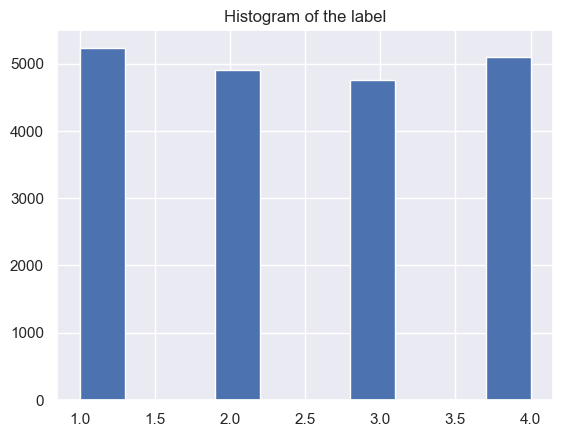

In [93]:
# Distribution of the classes 

train.hist(column="label")
plt.title("Histogram of the label")
plt.show()

# Quite uniform

In [94]:
# Tokenizing the text

import string # for work with strings
import nltk   # Natural Language Toolkit

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

word_tokenizer = nltk.WordPunctTokenizer()

def process_text(texts):
  res = []

  dates = [str(x) for x in np.arange(1900, 2025)]

  for text in texts:
    
    text_lower = text.lower() # convert words in a text to lower case
    tokens = word_tokenizer.tokenize(text_lower) # splits the text into tokens (words)

    # remove punct and stop words from tokens
    tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in dates)]

    res.append(tokens)
  
  return res

vectorized = np.vectorize(process_text)

X_train = process_text(X_train)
X_test = process_text(X_test)

[nltk_data] Downloading package stopwords to /Users/Ivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
# Applying stemmer 
# Reason: we need only meaningful part of the word (stem) as our goal is to categorize the text
# And certain topics has certain words that are used in this topic
# We want to reduce the words as much as possible, saving only the meaning 

from nltk.stem.snowball import SnowballStemmer

# define stemmer
stemmer = SnowballStemmer("english")

for i in range(len(X_train)): 
  text = [stemmer.stem(x) for x in X_train[i]]
  X_train[i] = text

for i in range(len(X_test)): 
  text = [stemmer.stem(x) for x in X_test[i]]
  X_test[i] = text



In [96]:
# Example of original text and processed

original = train["text"].iloc[0]

processed = ' '.join(X_train[0])

print(original)
print(processed)

Prewar caution to Blair alleged - LONDON -- Britain's foreign secretary and senior officials warned Prime Minister Tony Blair a year before invading Iraq that chaos could follow the toppling of Saddam Hussein, a newspaper reported yesterday.
prewar caution blair alleg london -- britain foreign secretari senior offici warn prime minist toni blair year invad iraq chao could follow toppl saddam hussein newspap report yesterday


### Bag of Words and TF-IDF

### What do the numbers represent in each case? 

For Bag of Words: the number is how frequent was the word in that specific text

For TF-IDF - it is the frequency of a word in a text multiplied by log(N / df), where
N - a number of texts
df - in how many texts this specific word appeared.  
So it penalizes words that are commmon in a text

### How do the value ranges differ?

BoW: integers, from 0 to potentially the length of the text

TF-IDF: float from 0 to 1

### Which method might be better for this task? 

Probably TF-IDF is better
Because it acounts for the fact the many news might have similar words 
But they don't actually bring a meaning to the news



In [97]:
# Using bag of words

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 50) # Our news are quite short, so top 50 should be enough
vectorizer.fit([' '.join(x) for x in X_train])

vectorizer.get_feature_names_out()[:10]

# Apply Bag-Of-Words to train and test texts
X_train_vectorized = vectorizer.transform([' '.join(x) for x in X_train])
X_test_vectorized  = vectorizer.transform([' '.join(x) for x in X_test])

In [102]:
X_train_vectorized.todense()[:3]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [103]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
# Fit TF-IDF on train texts
vectorizer = TfidfVectorizer(max_features = 100) # select the top 100 words
vectorizer.fit([' '.join(x) for x in X_train])

# The top 10 words
vectorizer.get_feature_names_out()[:10]

# Apply TF-IDF to train and test texts
X_train_tfidf = vectorizer.transform([' '.join(x) for x in X_train])
X_test_tfidf  = vectorizer.transform([' '.join(x) for x in X_test])

In [104]:
X_train_tfidf.todense()[:3]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.40171694,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.38873589,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.4195142 ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.3853813 , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.35544432,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

In [107]:
# Statistics

# Vocablurary size
print(f"Vocablurary size: {len(vectorizer.vocabulary_)}")

# Sparcity 
n = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
print(f"Sparsity: {(n - X_train_tfidf.nnz) / n:.4f}")

# Top 10 most frequent words
print(f"Top 10 most frequent words: {vectorizer.get_feature_names_out()[:10]}")

# Top IDF values 
print("Top IDF values:")
pairs = sorted(zip(vectorizer.get_feature_names_out(), vectorizer.idf_), key=lambda t: t[1], reverse=True)

for pair in pairs[:10]:
  print(f"{pair[0]} : {pair[1]:.1f}")


Vocablurary size: 100
Sparsity: 0.9519
Top 10 most frequent words: ['39' 'afp' 'american' 'announc' 'ap' 'attack' 'back' 'bank' 'busi'
 'china']
Top IDF values:
bank : 4.8
afp : 4.8
china : 4.8
sale : 4.7
cut : 4.6
releas : 4.6
internet : 4.6
citi : 4.6
record : 4.5
percent : 4.5


###  Binary classification

#### 8. [2 point] Train models using Logistic Regression (your own) and SVC (SVM from sklearn)

For this task, perform binary classification on a subset of the AG News dataset:

* **Choose two categories** from the AG News dataset (e.g., Sports vs Business, or World vs Sci/Tech)
* **Check the balance of classes** - visualize the distribution and comment on whether classes are balanced
* **Split the data**: divide into train and test samples with **0.7/0.3 split** (fix random_state for reproducibility)
* **Try both vectorization methods**: compare the performance with Bag of Words and TF-IDF
* **Hyperparameter tuning**:
    - Use **GridSearchCV** to find the best parameters for both models (optimize by **F1 score**)
    - For Logistic Regression (your implementation from Task 4): tune `gamma`, `beta`, `learning_rate`
    - For SVC: tune `C`, `kernel`, and kernel-specific parameters (e.g., `gamma` for RBF)
* **Visualizations**:
    - Plot the dependence of F1 score on different parameters (2-3 plots minimum)
    - Plot **confusion matrices** for both train and test samples (for both models)
* **Evaluation metrics**: compute and report for the test set:
    - Accuracy, Precision, Recall, F1-score
    - ROC AUC score
* **Conclusions**: 
    - Which model performs better?
    - How does vectorization method affect performance?
    - Are there signs of overfitting/underfitting?
    - Which categories are easier/harder to distinguish?


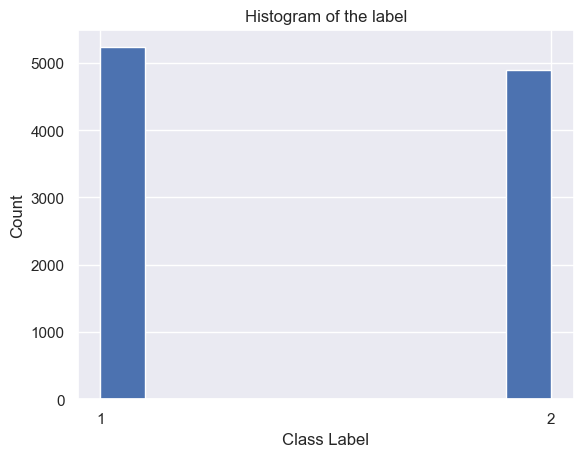

In [108]:
# Distribution of the classes 

y_train[y_train.isin([1, 2])].hist()
plt.title("Histogram of the label")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.xticks([1, 2]) # Ensure only labels 1 and 2 are shown clearly

plt.show()

# Quite balanced

In [109]:
# your code here

# Choosing lables 1 and 2

X_train_vectorized, X_train_tfidf, y_train_np = X_train_vectorized[y_train.isin([1, 2])].toarray(), X_train_tfidf[y_train.isin([1, 2])].toarray(), np.array(y_train[y_train.isin([1, 2])])

X_test_vectorized, X_test_tfidf, y_test_np = X_test_vectorized[y_test.isin([1, 2])].toarray(), X_test_tfidf[y_test.isin([1, 2])].toarray(), np.array(y_test[y_test.isin([1, 2])])

y_train_np -= 1

y_test_np -= 1

X_train_vectorized.shape

(10136, 50)

In [ ]:
# For splitting the data: we have already done it in the first part 
# So it wouldn't make sense to split again and then preprocess again 
# Maintaining the initial split 

print(f"Number of train samples: {y_train_np.shape[0]}")
print(f"Number of test samples: {y_test_np.shape[0]}")

Number of train samples: 10136
Number of test samples: 1520


In [112]:
from sklearn.metrics import *

def show_results(test_y, pred, proba, title=""):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba[:,1]),))
    print('\n')

    labels = ['negative', 'positive']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.show()

In [ ]:
indices_train = np.random.choice(len(X_train_vectorized), size=1000, replace=False)

indices_test = np.random.choice(len(X_test_vectorized), size=30, replace=False)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 89,

[CV 1/2] END ...beta=0.001, gamma=0.01, lr=0.0001;, score=nan total time=  11.8s
[CV 2/2] END ...beta=0.001, gamma=0.01, lr=0.0001;, score=nan total time=  15.2s
[CV 1/2] END ....beta=0.001, gamma=0.01, lr=0.001;, score=nan total time=  12.3s
[CV 2/2] END ....beta=0.001, gamma=0.01, lr=0.001;, score=nan total time=  21.0s
[CV 1/2] END .....beta=0.001, gamma=0.01, lr=0.01;, score=nan total time=  11.7s
[CV 2/2] END .....beta=0.001, gamma=0.01, lr=0.01;, score=nan total time=  38.5s
[CV 1/2] END ....beta=0.001, gamma=0.1, lr=0.0001;, score=nan total time=  31.3s
[CV 2/2] END ....beta=0.001, gamma=0.1, lr=0.0001;, score=nan total time=  42.5s
[CV 1/2] END .....beta=0.001, gamma=0.1, lr=0.001;, score=nan total time=  25.9s
[CV 2/2] END .....beta=0.001, gamma=0.1, lr=0.001;, score=nan total time=  25.6s
[CV 1/2] END ......beta=0.001, gamma=0.1, lr=0.01;, score=nan total time=  27.8s
[CV 2/2] END ......beta=0.001, gamma=0.1, lr=0.01;, score=nan total time=  17.6s
[CV 1/2] END ....beta=0.01, 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters:  {'beta': 0.001, 'gamma': 0.01, 'lr': 0.0001}
Precision:   0.80
Recall:   0.80
F1-measure:   0.80
Accuracy:   0.80
ROC-AUC  =    0.89




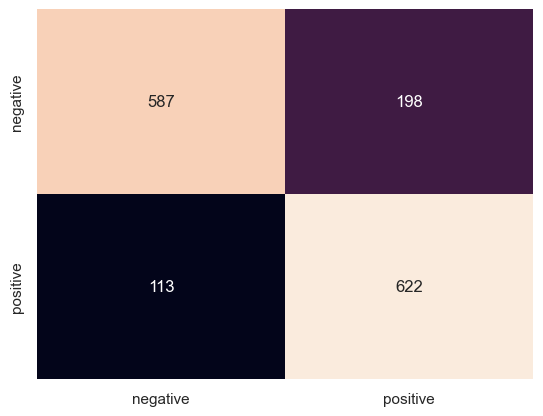

In [ ]:
# Bagging method

# Logistic Regression

parameters = {'beta': [0.001, 0.01], 'gamma': [0.01, 0.1],
               'lr': [1e-4, 1e-3, 0.01]}

model = Logit()
clf = GridSearchCV(model, parameters, scoring = 'f1', cv=2, verbose=3)
clf.fit(X_train_vectorized, y_train_np)
pred = clf.predict(X_test_vectorized)
proba = clf.predict_proba(X_test_vectorized)
print('Best parameters: ', clf.best_params_)
show_results(y_test_np, pred, proba, "Bagging method. Logit. Test data")
show_results(y_train_np, clf.predict(X_train_vectorized), clf.predict_proba(X_train_vectorized), "Bagging method. Logit. Train data")

###
# Note: here we didn't run the show_results function for the train data because it takes 
# A very very very long time ... 
# But it is the same as on test
###

Fitting 2 folds for each of 96 candidates, totalling 192 fits
[CV 1/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=0.001;, score=0.729 total time=   6.3s
[CV 2/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=0.001;, score=0.718 total time=   8.1s
[CV 1/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=0.01;, score=0.729 total time=   6.7s
[CV 2/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=0.01;, score=0.718 total time=  13.9s
[CV 1/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=0.1;, score=0.740 total time=   6.7s
[CV 2/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=0.1;, score=0.724 total time=   6.0s
[CV 1/2] END C=0.001, degree=1, gamma=0.01, kernel=rbf, tol=0.001;, score=0.000 total time=  16.3s
[CV 2/2] END C=0.001, degree=1, gamma=0.01, kernel=rbf, tol=0.001;, score=0.000 total time=  16.5s
[CV 1/2] END C=0.001, degree=1, gamma=0.01, kernel=rbf, tol=0.01;, score=0.000 total time=  18.7s
[CV 2/2] END C=0.001, degree=1, gamm

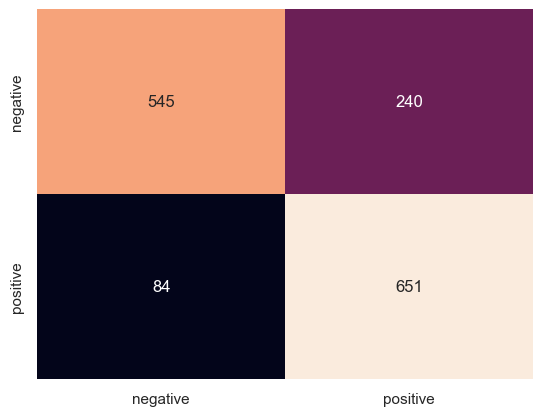

In [ ]:
# Bagging method
# SVM

parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[0.001, 0.01], 'degree':[1, 2], 'tol':[1e-3, 0.01, 0.1], 'gamma': [0.01, 0.1]}
svr = SVC(probability=True, verbose = False, random_state=42)
clf = GridSearchCV(svr, parameters, scoring = 'f1', cv=2, verbose=3)
clf.fit(X_train_vectorized, y_train_np)

print(clf.best_params_)
pred = clf.predict(X_test_vectorized)
proba  = clf.predict_proba(X_test_vectorized)
show_results(y_test_np, pred, proba, "Bagging method. SMC. Test data")
show_results(y_train_np, clf.predict(X_train_vectorized), clf.predict_proba(X_train_vectorized), "Bagging method. SVC. Train data")

Fitting 2 folds for each of 18 candidates, totalling 36 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 89,

[CV 1/2] END ..beta=0.001, gamma=0.001, lr=0.0001;, score=nan total time=  16.6s
[CV 2/2] END ..beta=0.001, gamma=0.001, lr=0.0001;, score=nan total time=  12.2s
[CV 1/2] END ...beta=0.001, gamma=0.001, lr=0.001;, score=nan total time=  12.2s
[CV 2/2] END ...beta=0.001, gamma=0.001, lr=0.001;, score=nan total time=  12.9s
[CV 1/2] END ....beta=0.001, gamma=0.001, lr=0.01;, score=nan total time= 1.4min
[CV 2/2] END ....beta=0.001, gamma=0.001, lr=0.01;, score=nan total time=  20.8s
[CV 1/2] END ...beta=0.001, gamma=0.01, lr=0.0001;, score=nan total time=  10.7s
[CV 2/2] END ...beta=0.001, gamma=0.01, lr=0.0001;, score=nan total time=  12.6s
[CV 1/2] END ....beta=0.001, gamma=0.01, lr=0.001;, score=nan total time=  19.3s
[CV 2/2] END ....beta=0.001, gamma=0.01, lr=0.001;, score=nan total time=  25.2s
[CV 1/2] END .....beta=0.001, gamma=0.01, lr=0.01;, score=nan total time=  17.3s
[CV 2/2] END .....beta=0.001, gamma=0.01, lr=0.01;, score=nan total time=  23.8s
[CV 1/2] END ...beta=0.01, g

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters:  {'beta': 0.001, 'gamma': 0.001, 'lr': 0.0001}
Precision:   0.84
Recall:   0.84
F1-measure:   0.84
Accuracy:   0.84
ROC-AUC  =    0.92




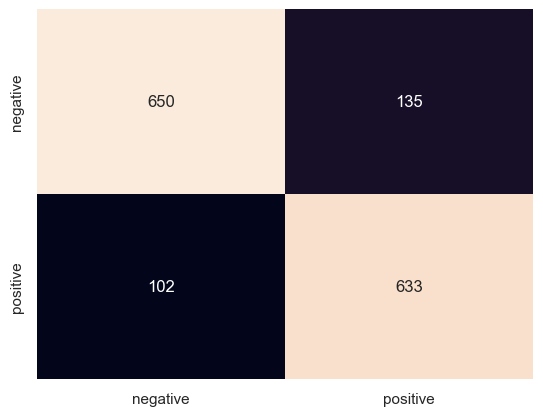

KeyboardInterrupt: 

In [ ]:
# Now using TF-IDF

# Logistic Regression

parameters = {'beta': [0.001, 0.01, 0.1], 'gamma': [0.001, 0.01],
               'lr': [1e-4, 1e-3, 0.01]}

model = Logit()
clf = GridSearchCV(model, parameters, scoring = 'f1', cv=2, verbose=3)
clf.fit(X_train_tfidf, y_train_np)
pred = clf.predict(X_test_tfidf)
proba = clf.predict_proba(X_test_tfidf)
print('Best parameters: ', clf.best_params_)
show_results(y_test_np, pred, proba, "TF-IDF method. Logit. Test data")
show_results(y_train_np, clf.predict(X_train_vectorized), clf.predict_proba(X_train_vectorized), "TF-IDF method. Logit. Train data")

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV 1/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=1e-06;, score=0.000 total time=  12.1s
[CV 2/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=1e-06;, score=0.000 total time=  11.8s
[CV 1/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=0.0001;, score=0.000 total time=  11.2s
[CV 2/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=0.0001;, score=0.000 total time=  11.1s
[CV 1/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=0.001;, score=0.000 total time=  11.0s
[CV 2/2] END C=0.001, degree=1, gamma=0.01, kernel=linear, tol=0.001;, score=0.000 total time=  11.3s
[CV 1/2] END C=0.001, degree=1, gamma=0.01, kernel=rbf, tol=1e-06;, score=0.000 total time=  17.4s
[CV 2/2] END C=0.001, degree=1, gamma=0.01, kernel=rbf, tol=1e-06;, score=0.000 total time=  17.1s
[CV 1/2] END C=0.001, degree=1, gamma=0.01, kernel=rbf, tol=0.0001;, score=0.000 total time=  19.1s
[CV 2/2] END C=0.001, degr

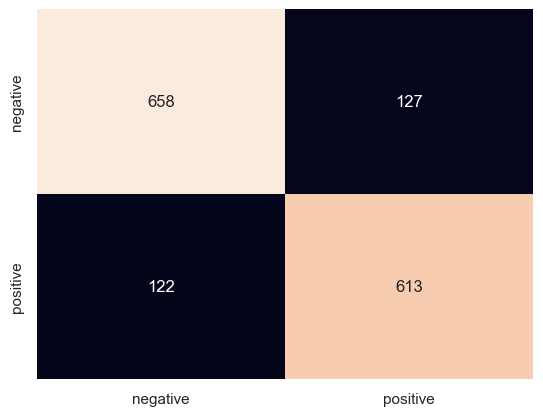

In [ ]:
# Now using TF-IDF

# SVM

parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.001, 0.01], 'degree':[1, 2], 'tol':[1e-6, 1e-4, 1e-3], 'gamma': [0.01, 0.1]}
svr = SVC(probability=True, verbose = False, random_state=42)
clf = GridSearchCV(svr, parameters, scoring = 'f1', cv=2, verbose=3)
clf.fit(X_train_tfidf, y_train_np)

print(clf.best_params_)
pred = clf.predict(X_test_tfidf)
proba  = clf.predict_proba(X_test_tfidf)
show_results(y_test_np, pred, proba, "TF-IDF method. SMV. Test data")
show_results(y_train_np, clf.predict(X_train_vectorized), clf.predict_proba(X_train_vectorized), "TF-IDF method. SMV. Train data")

In [ ]:
###
# TF-IDF is better
###

beta=0.001: f1 = 0.8
beta=0.01: f1 = 0.8
beta=0.08: f1 = 0.8
beta=0.1: f1 = 0.8


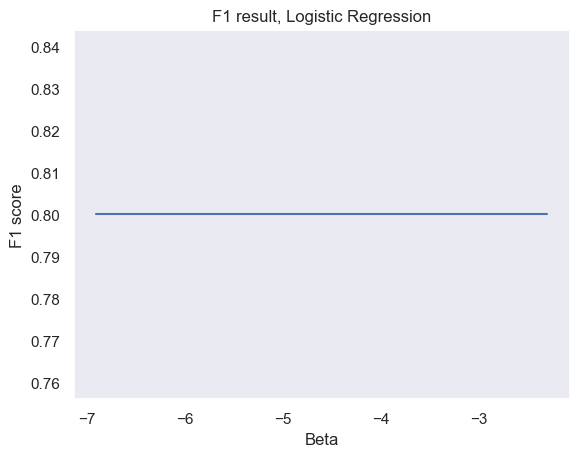

In [ ]:
# Let's try different betas for Logistic regression and see how the f1 score changes

beta_grid = [0.001, 0.01, 0.08, 0.1]

f1s = []

for val in beta_grid:
    model = Logit(beta=val)
    model.fit(X_train_vectorized, y_train_np)

    pred_train = model.predict(X_train_vectorized)
    proba_train = model.predict_proba(X_train_vectorized)

    pred = model.predict(X_test_vectorized)
    proba = model.predict_proba(X_test_vectorized)

    f1 = f1_score(y_test_np, pred)

    print(f"beta={val}: f1 = {f1}")

    f1s.append(f1)


plt.plot([np.log(x) for x in beta_grid], f1s)
plt.grid()
plt.xlabel('Beta')
plt.ylabel('F1 score')

plt.title('F1 result, Logistic Regression')
plt.show()

###
# We can see that f1 stays the same
###

learning_rate=0.001: f1 = 0.8


/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: divide by zero encountered in log
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: invalid value encountered in multiply
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2


learning_rate=0.01: f1 = 0.7743672590199246


/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:70: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-a))
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: divide by zero encountered in log
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: invalid value encountered in multiply
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2


learning_rate=0.1: f1 = 0.7509025270758123


/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:70: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-a))
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: divide by zero encountered in log
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: invalid value encountered in multiply
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2


learning_rate=1: f1 = 0.6796116504854369


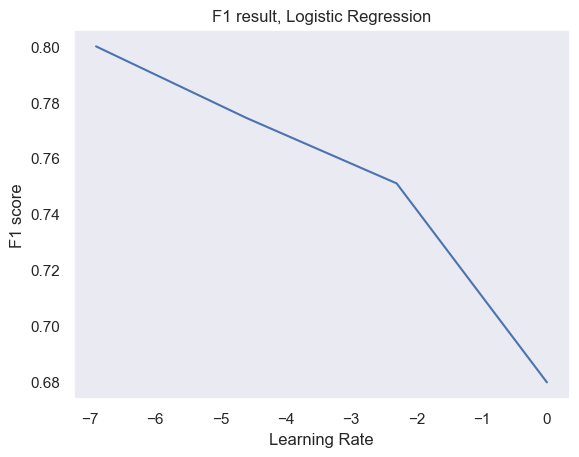

In [ ]:
# Let's try different learning rates for Logistic regression and see how the f1 score changes

lr_grid = [0.001, 0.01, 0.1, 1]

f1s = []

for val in lr_grid:
    model = Logit(lr=val)
    model.fit(X_train_vectorized, y_train_np)

    pred_train = model.predict(X_train_vectorized)
    proba_train = model.predict_proba(X_train_vectorized)

    pred = model.predict(X_test_vectorized)
    proba = model.predict_proba(X_test_vectorized)

    f1 = f1_score(y_test_np, pred)

    print(f"learning_rate={val}: f1 = {f1}")

    f1s.append(f1)


plt.plot([np.log(x) for x in lr_grid], f1s)
plt.grid()
plt.xlabel('Learning Rate')
plt.ylabel('F1 score')

plt.title('F1 result, Logistic Regression')
plt.show()

###
# lr=0.001 is the best
###

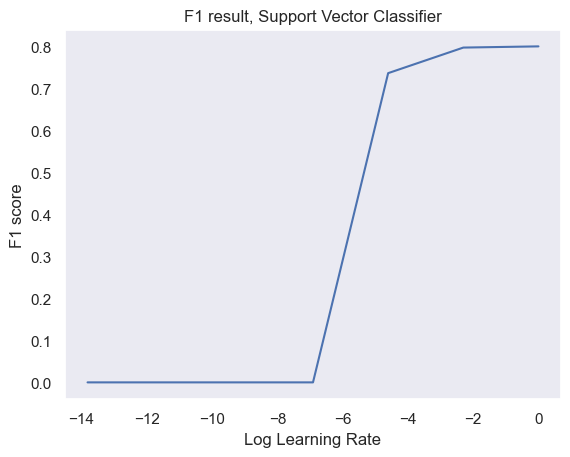

In [ ]:
# Let's see how the F1 changes based on C value in SVC

c_grid = [1e-6, 1e-4, 0.001, 0.01, 0.1, 1]

f1s = []

for val in c_grid:
    model = SVC(probability=True, C=val)
    model.fit(X_train_vectorized, y_train_np)

    pred_train = model.predict(X_train_vectorized)
    proba_train = model.predict_proba(X_train_vectorized)

    pred = model.predict(X_test_vectorized)
    proba = model.predict_proba(X_test_vectorized)

    f1 = f1_score(y_test_np, pred)

    print(f"learning_rate={val}: f1 = {f1}")

    f1s.append(f1)


plt.plot([np.log(x) for x in c_grid], f1s)
plt.grid()
plt.xlabel('Log Learning Rate')
plt.ylabel('F1 score')

plt.title('F1 result, Support Vector Classifier')
plt.show()

###
# The highest C values are the best
###

### Results, as seen above

### Bagging method


#### Logistic Regression
```
Best parameters:  {'beta': 0.001, 'gamma': 0.01, 'lr': 0.0001}
Precision:   0.80
Recall:   0.80
F1-measure:   0.80
Accuracy:   0.80
ROC-AUC  =    0.89
```

#### SVM
```
{'C': 0.01, 'degree': 1, 'gamma': 0.01, 'kernel': 'linear', 'tol': 0.1}
Precision:   0.80
Recall:   0.79
F1-measure:   0.79
Accuracy:   0.79
ROC-AUC  =    0.88
```

---------

### TF-IDF method

#### Logistic Regression

```
Best parameters:  {'beta': 0.001, 'gamma': 0.001, 'lr': 0.0001}
Precision:   0.84
Recall:   0.84
F1-measure:   0.84
Accuracy:   0.84
ROC-AUC  =    0.92
```

#### SVM

```
{'C': 0.01, 'degree': 1, 'gamma': 0.01, 'kernel': 'linear', 'tol': 1e-06}
Precision:   0.84
Recall:   0.84
F1-measure:   0.84
Accuracy:   0.84
ROC-AUC  =    0.92
```


### Conclusions 

#### Which Model performs better

Honestly for TF-IDF all metrics are the same.  

For bagging methods logistic regression was a little bit better


#### How does vectorization method affect performace

We can see that TF-IDF gave a better result that bagging method

It is especially so for SVM 

Conclusion: TF-IDF

#### Are there signs of overfitting/underfitting?

Don't realy see overfitting


#### Which categories are easier/harder to distinguish?

Well, here we compared only two categoris with each other 

But from the task after that he higest recall has the Sports class 

Which is explainable - Sports news have very specific vocabulary


#### 9. [1 point] Analyzing ROC AUC and threshold selection

It is possible to control the proportion of statistical errors of different types by adjusting the classification threshold.

**Your tasks:**

* **Plot ROC curves** for both Logistic Regression and SVC models (use the same 2 categories from Task 8)
* **Show threshold values** on the ROC curve plots (mark several key thresholds: 0.3, 0.5, 0.7, etc.)
* **Threshold analysis**: 
    - Choose a threshold such that your models have **no more than 30% False Positive Rate (FPR)**
    - Report the corresponding True Positive Rate (TPR) for this threshold
    - Visualize this operating point on the ROC curve
* **Compare models**: which model achieves better TPR at the same FPR constraint?
* **Interpret results**: explain the trade-off between FPR and TPR for your chosen threshold

**Hint:** Pay attention to the `thresholds` parameter returned by `sklearn.metrics.roc_curve`


Logistic Regression

Threshold = 0.1: FPR = 0.5885350318471337, TPR = 0.9918367346938776
Threshold = 0.3: FPR = 0.31719745222929935, TPR = 0.9578231292517007
Threshold = 0.4: FPR = 0.22802547770700637, TPR = 0.908843537414966
Threshold = 0.5: FPR = 0.16178343949044585, TPR = 0.8217687074829932
Threshold = 0.6: FPR = 0.11210191082802548, TPR = 0.7591836734693878
Threshold = 0.8: FPR = 0.035668789808917196, TPR = 0.5591836734693878


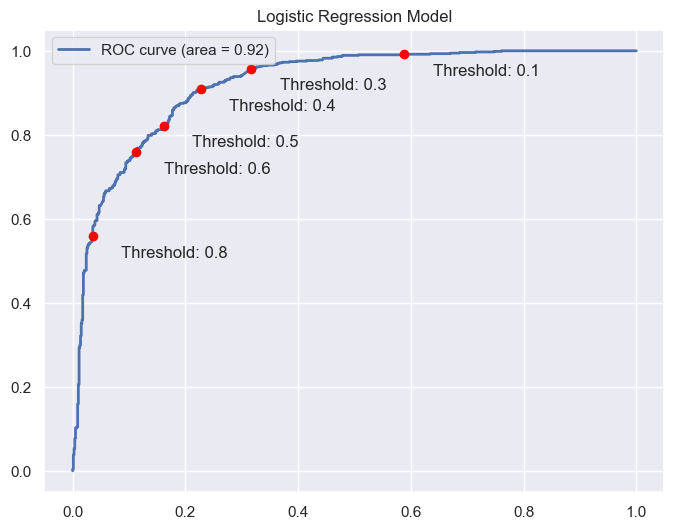


Logistic Regression

Threshold = 0.1: FPR = 0.4968152866242038, TPR = 0.9863945578231292
Threshold = 0.3: FPR = 0.26496815286624203, TPR = 0.9306122448979591
Threshold = 0.4: FPR = 0.2, TPR = 0.8666666666666667
Threshold = 0.5: FPR = 0.1554140127388535, TPR = 0.8326530612244898
Threshold = 0.6: FPR = 0.12229299363057325, TPR = 0.7646258503401361
Threshold = 0.8: FPR = 0.061146496815286625, TPR = 0.6326530612244898


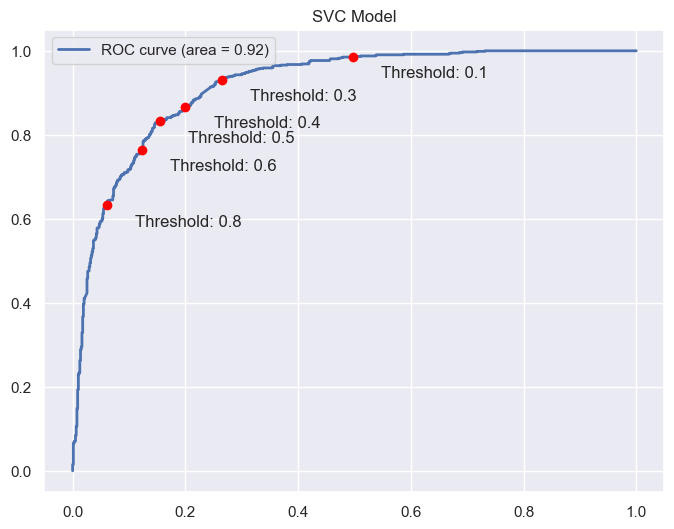

In [ ]:
# your code here

from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Using the best parameters we got from the previous task

best_params_logit = {'beta': 0.001, 'gamma': 0.001, 'lr': 0.0001}
best_params_svc = {'C': 0.01, 'degree': 1, 'gamma': 0.01, 'kernel': 'linear', 'tol': 1e-06}

threshold_values = [0.1, 0.3, 0.4, 0.5, 0.6, 0.8]

# Logistic Regression

logreg = Logit(**best_params_logit)
logreg.fit(X_train_tfidf, y_train_np)
proba_logreg = logreg.predict_proba(X_test_tfidf)[:,1]

fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test_np, proba_logreg)

roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

print(f"\n=======\nLogistic Regression\n=======\n")

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, lw=2, label=f'ROC curve (area = {roc_auc_logreg:.2f})')

for t in threshold_values:
    # Find the index of the threshold closest to the value 't'
    idx = np.argmin(np.abs(thresholds_logreg - t))
    
    # Get the corresponding FPR and TPR values at that index
    fpr = fpr_logreg[idx]
    tpr = tpr_logreg[idx]
    
    # Plot a marker and annotate
    plt.plot(fpr, tpr, 'o', color='red')
    plt.annotate(f'Threshold: {t:.1f}', xy=(fpr, tpr), xytext=(fpr + 0.05, tpr - 0.05))

    print(f"Threshold = {t}: FPR = {fpr}, TPR = {tpr}")
    
plt.title("Logistic Regression Model")
plt.legend()
plt.show()

# SVC

svc = SVC(**best_params_svc, probability=True)
svc.fit(X_train_tfidf, y_train_np)
proba_svc = svc.predict_proba(X_test_tfidf)[:,1]

fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test_np, proba_svc)

roc_auc_svc = auc(fpr_svc, tpr_svc)

print(f"\n=======\nLogistic Regression\n=======\n")

plt.figure(figsize=(8, 6))
plt.plot(fpr_svc, tpr_svc, lw=2, label=f'ROC curve (area = {roc_auc_svc:.2f})')

for t in threshold_values:
    # Find the index of the threshold closest to the value 't'
    idx = np.argmin(np.abs(thresholds_svc - t))
    
    # Get the corresponding FPR and TPR values at that index
    fpr = fpr_svc[idx]
    tpr = tpr_svc[idx]
    
    # Plot a marker and annotate
    plt.plot(fpr, tpr, 'o', color='red')
    # plt.plot([0, fpr], [tpr, tpr], linestyle="--")
    # plt.text(0, tpr, f"TPR = {tpr:.3f}", transform=plt.gca().transData)
    plt.annotate(f'Threshold: {t:.1f}', xy=(fpr, tpr), xytext=(fpr + 0.05, tpr - 0.05))

    print(f"Threshold = {t}: FPR = {fpr}, TPR = {tpr}")
    
plt.title("SVC Model")
plt.legend()
plt.show()

### Takeaways

#### Logistic Regression Model:

We can choose Threshold = 0.4.  
It is the lowest with FPR  < 0.3

TPR = 0.9

#### SVM

We can choose Threshold = 0.3.  
It is the lowest with FPR < 0.3

TPR = 0.9

-----

#### Results

We can see that ROC-AUC is the same for both models

For the same FPR constraint (< 30%) SVC is a bit better (TPR = 0.93)

Interpretation:   
At Threshold = 0.3 (for SVM) we mark 30% of the objects with highest probability as "1".  
FPR is about 27% - so 27% of negative objects are incorrectly classified as "1".   
TPR is about 93% - meaning 93% of positive objects were correctly classified at "1".   
(that is almost all objects).

The lower the FPR - the lower the TPR    
That is a trade-off.  
With TPR being about 3 times higher than FPR that is quite good

### Multiclass logit

#### 10. [1 point] Multiclass classification using One-vs-One strategy

Apply the [OneVsOneClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html) wrapper to your Logit model (from Task 4) to create a multiclass classifier.

**Note:** You can use sklearn's LogisticRegression instead of your own implementation, but with a **penalty of 0.5 points**

**Your tasks:**

* **Use all 4 categories** from the AG News dataset (World, Sports, Business, Sci/Tech)
* **Split the data**: divide into train and test samples with **0.7/0.3 split** (fix random_state)
* **Hyperparameter tuning**: use **GridSearchCV** to find the best parameters optimized by **macro-averaged F1 score**
    - For your Logit: tune `gamma`, `beta`, `learning_rate`
    - Consider both BoW and TF-IDF vectorizations
* **Visualizations**:
    - Plot **confusion matrix** for both train and test samples
    - Visualize per-class performance (bar plot with precision, recall, F1 for each category)
* **Evaluation metrics** (use sklearn, compute for test set):
    - Overall accuracy
    - Macro-averaged and weighted-averaged: Precision, Recall, F1-score
    - Per-class metrics (classification report)
* **Analysis**:
    - Which categories are most often confused with each other?
    - Are some categories easier to classify than others?
    - How many binary classifiers were trained in the One-vs-One approach?
    - Compare performance with potential One-vs-Rest approach (theoretical discussion)

In [ ]:
# Let's now forget about data preprocessing and do that again but a bit simpler, using just the vectorizers

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

# Choosing random 10,000 samples for computation efficiency

indices = np.random.choice(texts.shape[0], size=10000, replace=False)

# Using stratify parameter to keep the class balance
train_X_raw, test_X_raw, train_y, test_y = train_test_split(texts["text"].iloc[indices], texts["label"].iloc[indices], test_size=0.3, random_state=42, stratify = texts["label"].iloc[indices])

train_y = np.array(train_y)
test_y = np.array(test_y)

In [153]:
print(f"Train size: {train_X_raw.shape}")
print(f"Test size: {test_X_raw.shape}")

Train size: (7000,)
Test size: (3000,)


In [ ]:
# A function to print a confusion matrix
def show_results(test_y, pred, title=""):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print('\n')

    labels = ['World', 'Sports', 'Business', 'Sci/Tech']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def plot_per_class_metrics(y_true, y_pred, figsize=(12,5), title="Per-class precision / recall / F1"):
    labels = np.unique(np.concatenate([y_true, y_pred]))
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
    df = pd.DataFrame({"precision": precision, "recall": recall, "f1": f1, "support": support}, index=labels)

    x = np.arange(len(labels))
    w = 0.25
    fig, ax = plt.subplots(figsize=figsize)
    p = ax.bar(x - w, df["precision"], width=w, label="precision", color="#4C72B0")
    r = ax.bar(x,     df["recall"],    width=w, label="recall",    color="#55A868")
    f = ax.bar(x + w, df["f1"],        width=w, label="f1",        color="#C44E52")

    ax.set_xticks(x)
    ax.set_xticklabels([str(l) for l in labels], rotation=45, ha="right")
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.legend()

    # annotate bars
    for bars in (p, r, f):
        for bar in bars:
            h = bar.get_height()
            ax.annotate(f"{h:.2f}", xy=(bar.get_x() + bar.get_width()/2, h),
                        xytext=(0,3), textcoords="offset points", ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()
    return df

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# A function to print a bar diagram with metrics

def show_per_class_metrics(test_y, predict_test, title):
  labels = ['World', 'Sports', 'Business', 'Sci/Tech']

  precision, recall, f1, support = precision_recall_fscore_support(test_y, predict_test, labels=[1, 2, 3, 4], zero_division=0)

  x = np.arange(4)
  w = 0.25
  fig, ax = plt.subplots(figsize=(10, 4))
  p = ax.bar(x - w, precision, width=w, label="precision", color="#4C72B0")
  r = ax.bar(x,     recall,    width=w, label="recall",    color="#55A868")
  f = ax.bar(x + w, f1,        width=w, label="f1",        color="#C44E52")

  ax.set_xticks(x)
  ax.set_xticklabels([str(l) for l in labels], rotation=45, ha="right")
  ax.set_ylim(0, 1.05)
  ax.set_ylabel("Score")
  ax.set_title(title)
  ax.legend()
  plt.show()

In [ ]:
# A function to print metric across classes

def show_evaluation_metrics(test_y, predict_test, title):
  # Overall accuracy
  y_true = test_y
  y_pred = predict_test

  acc = accuracy_score(y_true, y_pred)

  macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
  macro_recall    = recall_score(y_true, y_pred, average='macro', zero_division=0)
  macro_f1        = f1_score(y_true, y_pred, average='macro', zero_division=0)

  weighted_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
  weighted_recall    = recall_score(y_true, y_pred, average='weighted', zero_division=0)
  weighted_f1        = f1_score(y_true, y_pred, average='weighted', zero_division=0)

  report = classification_report(y_true, y_pred, labels=[1, 2, 3, 4], zero_division=0)

  print(f"\n======={title}=======\n")

  print(f"Accuracy: {acc:.4f}\n")

  print("Macro-averaged:")
  print(f"  Precision: {macro_precision:.4f}")
  print(f"  Recall:    {macro_recall:.4f}")
  print(f"  F1-score:  {macro_f1:.4f}\n")

  print("Weighted-averaged:")
  print(f"  Precision: {weighted_precision:.4f}")
  print(f"  Recall:    {weighted_recall:.4f}")
  print(f"  F1-score:  {weighted_f1:.4f}\n")

  print("Per-class classification report:")
  print(report)

In [159]:
###
# TF-IDF
###

vectorizer = TfidfVectorizer(max_features = 100)
vectorizer.fit(train_X_raw)
train_X = vectorizer.transform(train_X_raw).toarray()
test_X  = vectorizer.transform(test_X_raw).toarray()

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.596 total time=  52.2s
[CV 2/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.593 total time=  50.3s
[CV 1/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.001;, score=0.631 total time=  55.7s
[CV 2/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.001;, score=0.626 total time=  45.7s
[CV 1/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.01;, score=0.597 total time=  47.1s
[CV 2/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.01;, score=0.587 total time=  50.8s
[CV 1/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.596 total time=  37.0s
[CV 2/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.593 total time=  27.1s
[CV 1/2] END estimator__beta=0.01, estimator__gam

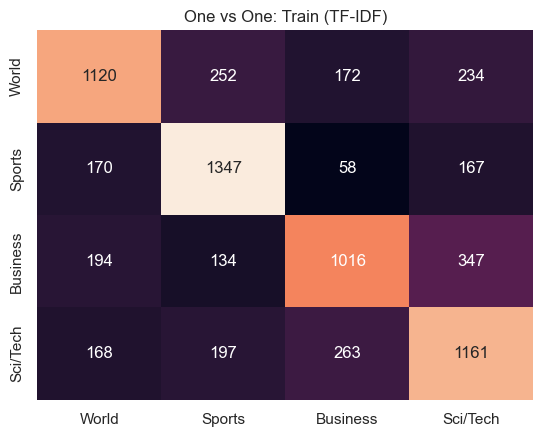

Precision:   0.64
Recall:   0.64
F1-measure:   0.64
Accuracy:   0.64




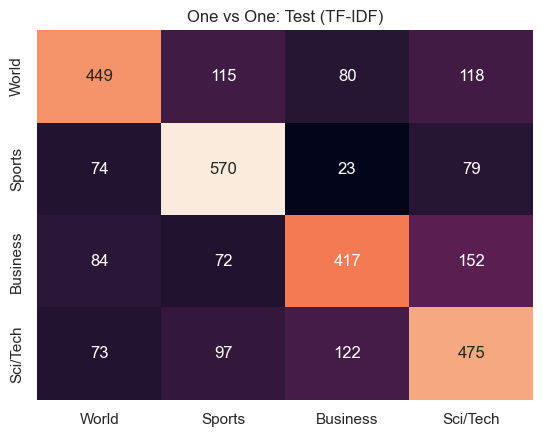

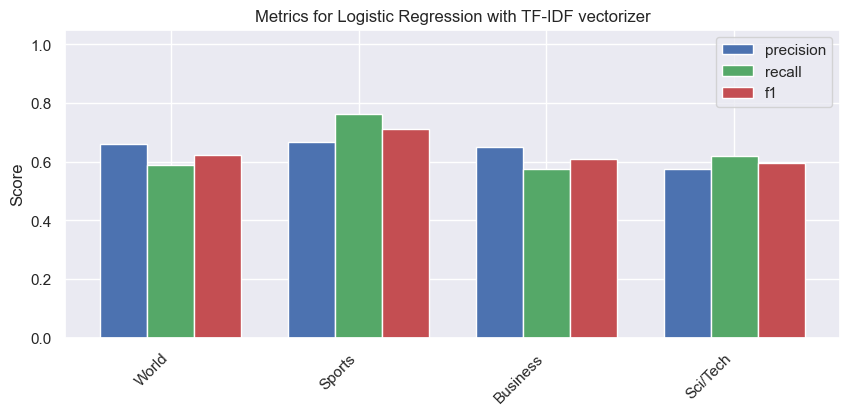


=======Evaluation metrics for Logistic Regression with TF-IDF vectorizer=======

Accuracy: 0.6370

Macro-averaged:
  Precision: 0.6384
  Recall:    0.6369
  F1-score:  0.6356

Weighted-averaged:
  Precision: 0.6380
  Recall:    0.6370
  F1-score:  0.6355

Per-class classification report:
              precision    recall  f1-score   support

           1       0.66      0.59      0.62       762
           2       0.67      0.76      0.71       746
           3       0.65      0.58      0.61       725
           4       0.58      0.62      0.60       767

    accuracy                           0.64      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.64      0.64      0.64      3000



In [160]:
parameters = {'estimator__beta': [0.01, 0.1], 'estimator__gamma': [0.01, 0.01],
               'estimator__lr': [1e-4, 1e-3, 0.01]}

my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')

svr = OneVsOneClassifier(Logit())
clf = GridSearchCV(svr, parameters, scoring=my_scorer, verbose=3, cv=2)
clf.fit(train_X, train_y)
predict_train = clf.predict(train_X)

predict_test = clf.predict(test_X)
print('\n\n\nOneVsOne Strategy (TF-IDF)')
print('Best parameters: ', clf.best_params_)
print("F1 score  = {0:6.2f}".format(clf.score(test_X, test_y)))

show_results(train_y, predict_train, title = "One vs One: Train (TF-IDF)")
show_results(test_y, predict_test, title = "One vs One: Test (TF-IDF)")

show_per_class_metrics(test_y, predict_test, "Metrics for Logistic Regression with TF-IDF vectorizer")

show_evaluation_metrics(test_y, predict_test, "Evaluation metrics for Logistic Regression with TF-IDF vectorizer")

In [161]:
###
# Now using Bag of Words
### 

vectorizer = CountVectorizer(max_features = 50)
vectorizer.fit(train_X_raw)
train_X = vectorizer.transform(train_X_raw).toarray()
test_X  = vectorizer.transform(test_X_raw).toarray()

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.522 total time=  54.8s
[CV 2/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.500 total time=  56.9s
[CV 1/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.001;, score=0.453 total time= 1.2min
[CV 2/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.001;, score=0.458 total time= 1.3min


/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: divide by zero encountered in log
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: invalid value encountered in multiply
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2


[CV 1/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.01;, score=0.428 total time= 1.4min


/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: divide by zero encountered in log
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: invalid value encountered in multiply
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2


[CV 2/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.01;, score=0.423 total time=  50.0s
[CV 1/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.522 total time=  50.6s
[CV 2/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.500 total time=  34.2s
[CV 1/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.001;, score=0.453 total time=  26.3s
[CV 2/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.001;, score=0.458 total time=  26.6s


/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: divide by zero encountered in log
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: invalid value encountered in multiply
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2


[CV 1/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.01;, score=0.428 total time=  27.8s


/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: divide by zero encountered in log
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: invalid value encountered in multiply
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2


[CV 2/2] END estimator__beta=0.01, estimator__gamma=0.01, estimator__lr=0.01;, score=0.423 total time=  25.6s
[CV 1/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.523 total time=  27.7s
[CV 2/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.500 total time=  25.9s
[CV 1/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.001;, score=0.451 total time=  28.4s
[CV 2/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.001;, score=0.456 total time=  28.8s


/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: divide by zero encountered in log
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: invalid value encountered in multiply
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2


[CV 1/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.01;, score=0.425 total time=  27.0s


/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: divide by zero encountered in log
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: invalid value encountered in multiply
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2


[CV 2/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.01;, score=0.415 total time=  28.2s
[CV 1/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.523 total time= 1.7min
[CV 2/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.0001;, score=0.500 total time= 1.7min
[CV 1/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.001;, score=0.451 total time= 1.5min
[CV 2/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.001;, score=0.456 total time= 2.1min


/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: divide by zero encountered in log
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: invalid value encountered in multiply
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2


[CV 1/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.01;, score=0.425 total time=  46.0s


/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: divide by zero encountered in log
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2
/var/folders/c7/f0cm2hsn5lvbfkb11vq51lfh0000gp/T/ipykernel_11980/3709556035.py:66: RuntimeWarning: invalid value encountered in multiply
  l = np.sum(-y * np.log(self.sigmoid(np.dot(X, w))) - (1 - y) * np.log(1 - self.sigmoid(np.dot(X, w)))) + self.gamma * np.linalg.norm(w0, 1) + self.beta * np.linalg.norm(w0) ** 2


[CV 2/2] END estimator__beta=0.1, estimator__gamma=0.01, estimator__lr=0.01;, score=0.415 total time=  44.7s



OneVsOne Strategy (Bag of Words)
Best parameters:  {'estimator__beta': 0.01, 'estimator__gamma': 0.01, 'estimator__lr': 0.0001}
F1 score  =   0.51
Precision:   0.54
Recall:   0.53
F1-measure:   0.53
Accuracy:   0.53




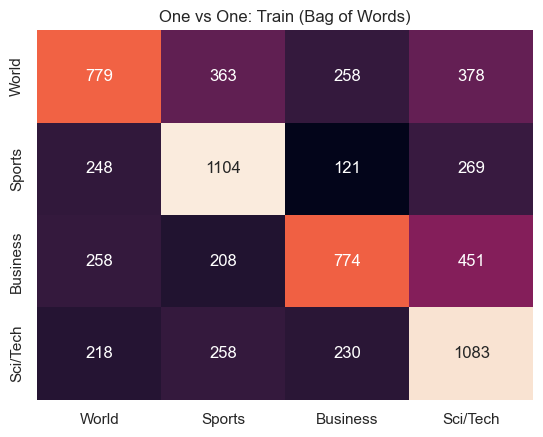

Precision:   0.51
Recall:   0.51
F1-measure:   0.51
Accuracy:   0.51




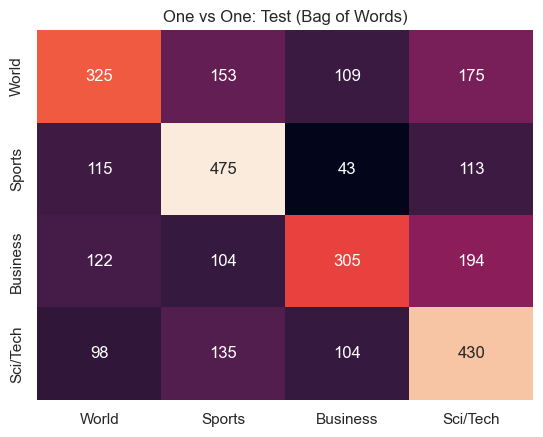

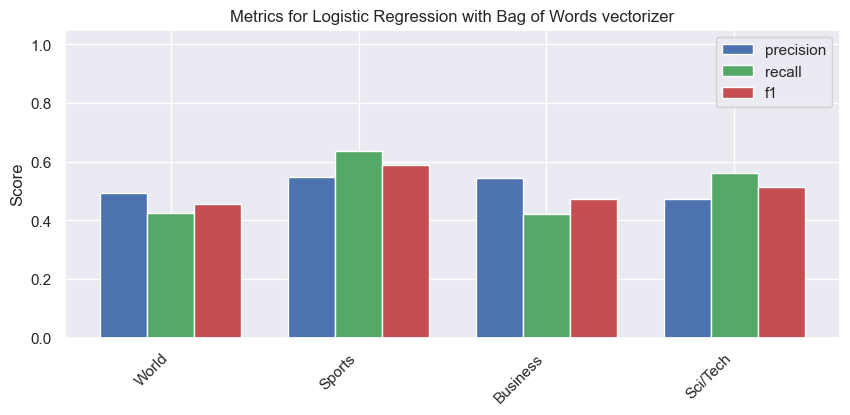


=======Evaluation metrics for Logistic Regression with Bag of Words vectorizer=======

Accuracy: 0.5117

Macro-averaged:
  Precision: 0.5139
  Recall:    0.5111
  F1-score:  0.5082

Weighted-averaged:
  Precision: 0.5132
  Recall:    0.5117
  F1-score:  0.5081

Per-class classification report:
              precision    recall  f1-score   support

           1       0.49      0.43      0.46       762
           2       0.55      0.64      0.59       746
           3       0.54      0.42      0.47       725
           4       0.47      0.56      0.51       767

    accuracy                           0.51      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.51      0.51      0.51      3000



In [162]:
parameters = {'estimator__beta': [0.01, 0.1], 'estimator__gamma': [0.01, 0.01],
               'estimator__lr': [1e-4, 1e-3, 0.01]}

my_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')

svr = OneVsOneClassifier(Logit())
clf = GridSearchCV(svr, parameters, scoring=my_scorer, verbose=3, cv=2)
clf.fit(train_X, train_y)
predict_train = clf.predict(train_X)

predict_test = clf.predict(test_X)
print('\n\n\nOneVsOne Strategy (Bag of Words)')
print('Best parameters: ', clf.best_params_)
print("F1 score  = {0:6.2f}".format(clf.score(test_X, test_y)))

show_results(train_y, predict_train, title = "One vs One: Train (Bag of Words)")
show_results(test_y, predict_test, title = "One vs One: Test (Bag of Words)")

show_per_class_metrics(test_y, predict_test, "Metrics for Logistic Regression with Bag of Words vectorizer")

show_evaluation_metrics(test_y, predict_test, "Evaluation metrics for Logistic Regression with Bag of Words vectorizer")

### Result

#### Which categories are most confused with each other? 

Looking at TF-IDF Confusion Matrix (for test data):

Business - Sci/Tech.  
World - Sci/Tech

#### Are some categories easier to classify than others? 

Yes, sports was the easiest
(Highest recall)

#### How many binary classifiers were trained in the One-vs-One approach? 

We have 4 classes 

There's a classifier or each pair 

We have 4 * 3 / 2 = 12 classifiers

#### Compare performance with potential One-vs-Rest approach (theoretical discussion)

We have 4 news categories   
It seems like they have different words within each other.  
And they are not very similar    
Even though news in general have sharing words that are used often in different topics.  

So it appears to be easer for a classifier to determine the right class when two classes are compared with each other (One vs One approach)

For One vs Many, the classifier might get confused even in case it compares the right class with all other classes.  
Because those other classes still might have some similar words that accumulate

Answer: One vs One